# LSTM Text classification using Tensorflow 2.0 Alpha

# Tensorflow 2.0 Alpha important information:
- [Official TF2 Alpha](https://www.tensorflow.org/alpha)
- [New Features in TF 2](https://medium.com/tensorflow/whats-coming-in-tensorflow-2-0-d3663832e9b8)
- [Standardizing on Keras for TF2](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a)
- [TF2 GPU installation guide](https://www.tensorflow.org/install/gpu)

# Importing Libraries

### Installing TF-gpu 2.0 Alpha

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import operator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

# Environment checks

#### Check Tensorflow Version

In [4]:
print(tf.__version__)

2.0.0-alpha0


#### Check GPU detection for tensorflow

In [5]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


#### Check if Eager execution is running
- Eager execution enables a more interactive frontend to TensorFlow, the details of which we will discuss much later.
- [Eager basics official guide](https://www.tensorflow.org/tutorials/eager/eager_basics)

In [6]:
print(tf.executing_eagerly())

True


In [7]:
print(tf.keras.__version__)

2.2.4-tf


# Importing data

In [8]:
df  = pd.read_csv("../input/train.csv")
df_test = pd.read_csv('../input/test.csv')


In [9]:
df[df.target==1].head(10)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1
127,0005de07b07a17046e27,How do I marry an American woman for a Green Card? How much do they charge?,1
144,00068875d7c82a5bcf88,"Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",1
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?,1
167,00075f7061837807c69f,In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own laws?,1


In [10]:
print("Number of questions: ", df.shape[0])

Number of questions:  1306122


# EDA on the Question Text corpus

## Target variable response rate
- __6.18 %__ questions are insincere in the provided dataset

In [11]:
df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [12]:
print("Percentage of insincere questions: {}".format(sum(df.target == 1)*100/len(df.target)))

Percentage of insincere questions: 6.187017751787352


## Wordclouds for the question text corpus
- This will show us the most frequently used words for sincere and insincere labeled questions

### Defining function for generating wordcloud

In [13]:
# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


### Wordcloud for sincere questions

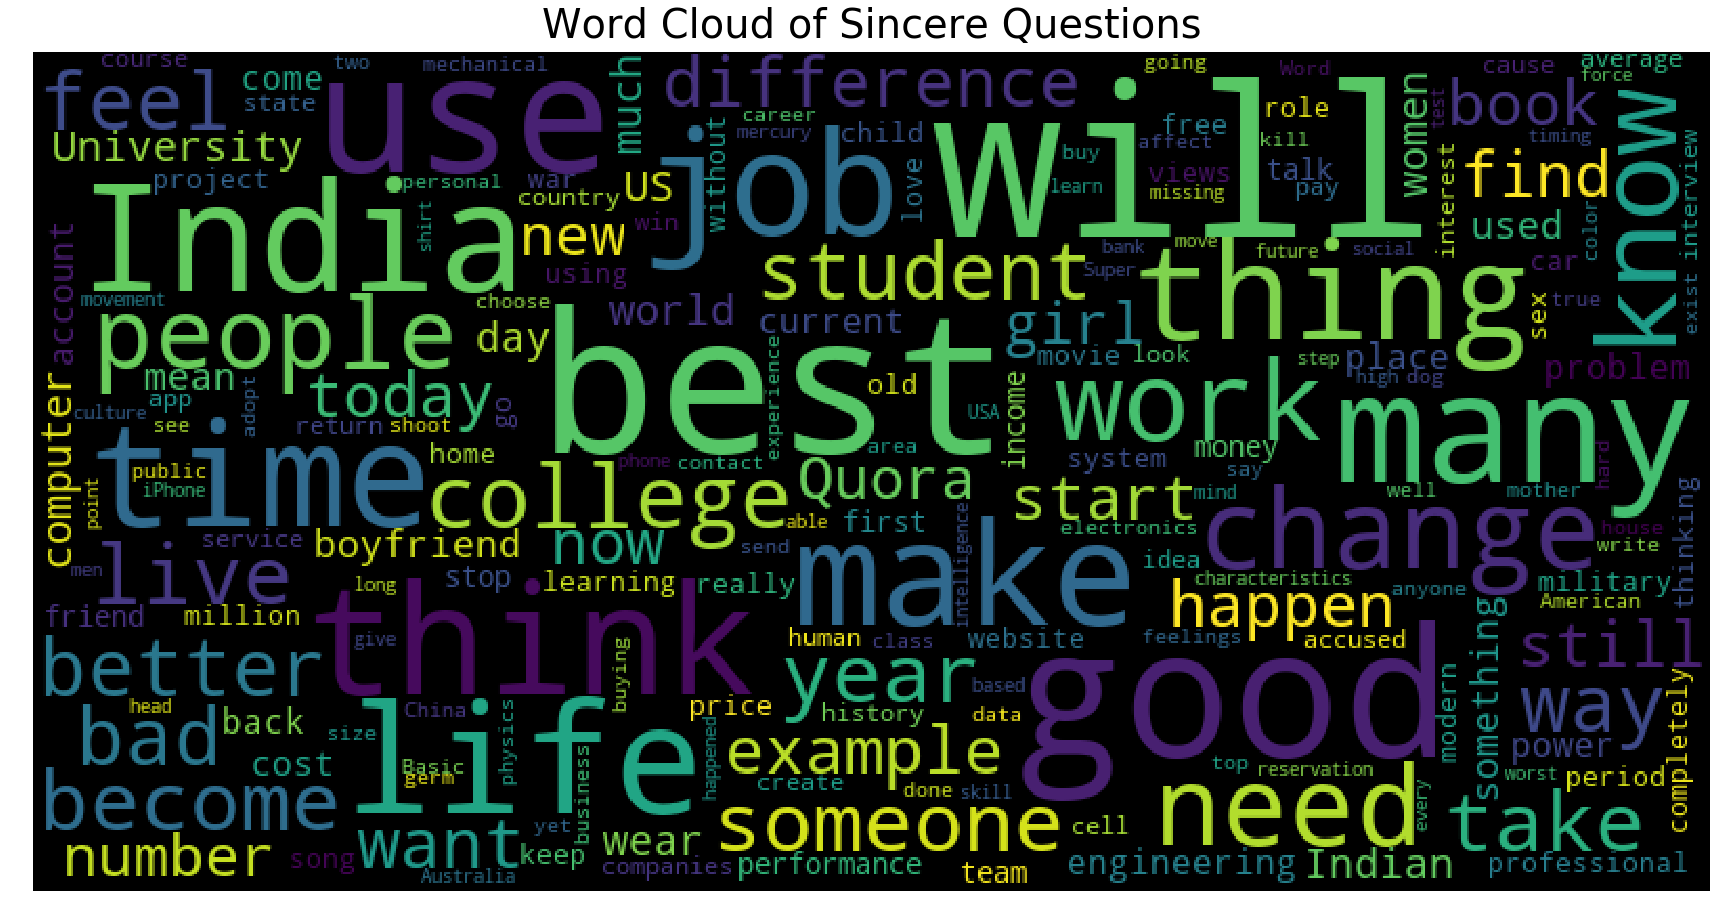

In [14]:
plot_wordcloud(df[df.target == 0]["question_text"], title="Word Cloud of Sincere Questions")

### Wordcloud for insincere questions
- We observe that insincere questions contain highly debated and emotion based topics of Trump, Muslims, America, Russia, Obama, Liberal etc.

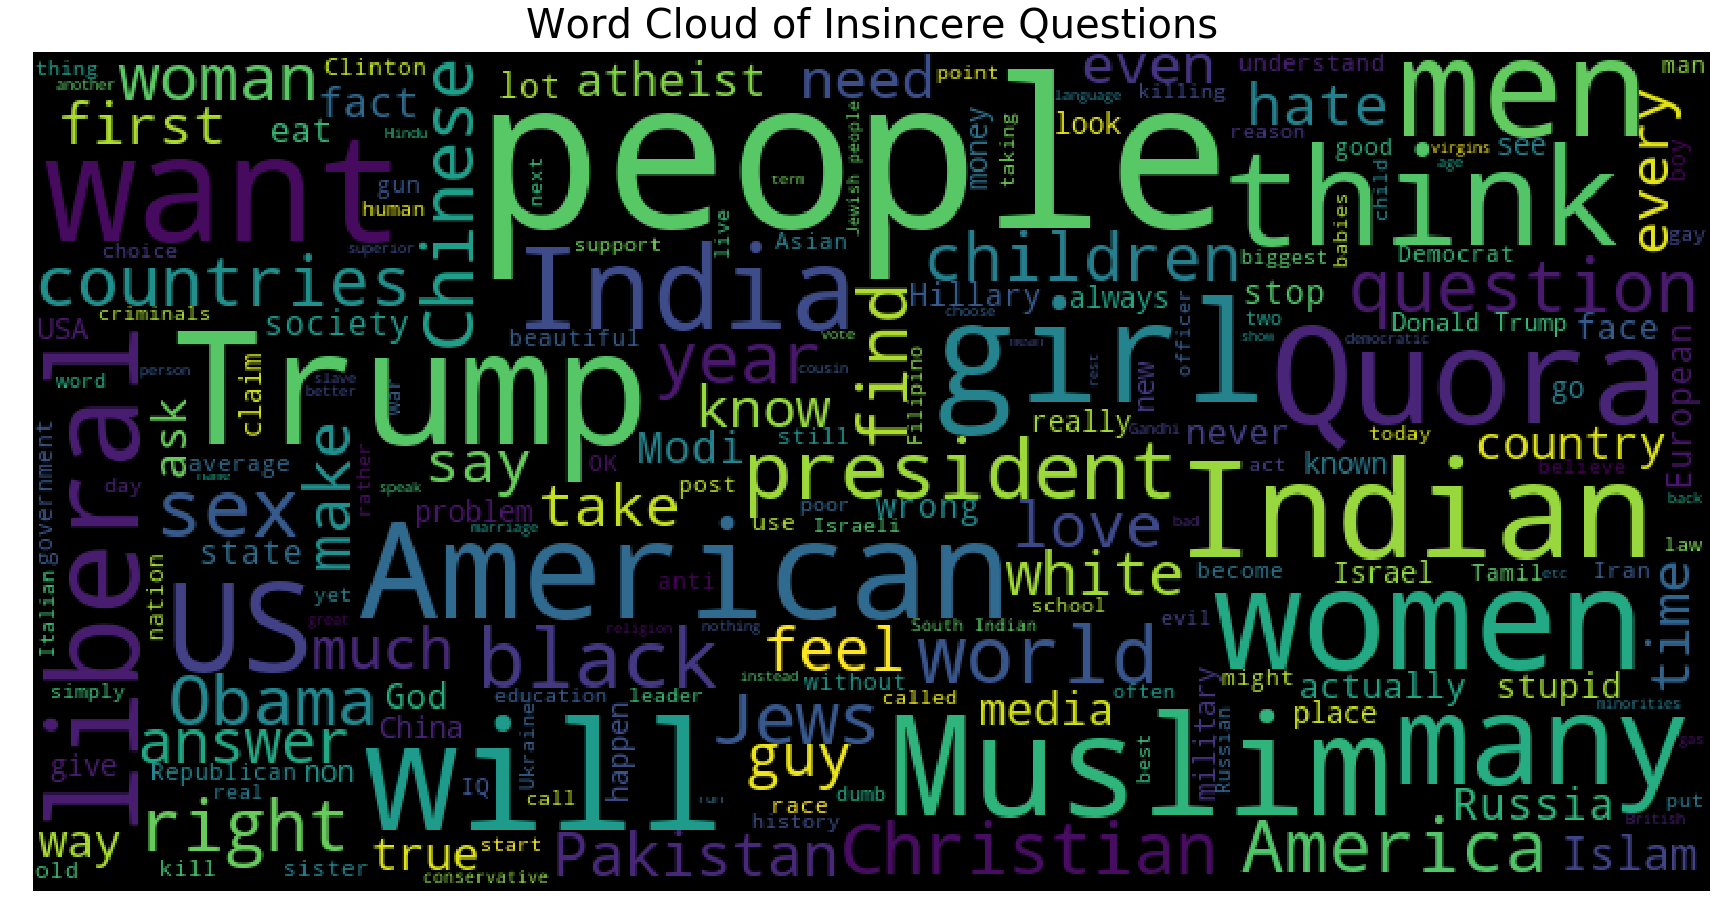

In [15]:
plot_wordcloud(df[df.target == 1]["question_text"], title="Word Cloud of Insincere Questions")

## Word frequency and n-gram frequency
- Frequency of words can show the most used words for sincere and insincere questions
- N-grams can be useful in distinguishing sincere and insincere questions by identifying patterns in topics

In [16]:
stopwords = set(STOPWORDS)

In [17]:
sincere_words = df[df.target==0].question_text.apply(lambda x: x.lower().split()).tolist()
insincere_words = df[df.target==1].question_text.apply(lambda x: x.lower().split()).tolist()

sincere_words = [item for sublist in sincere_words for item in sublist if item not in stopwords]
insincere_words = [item for sublist in insincere_words  for item in sublist if item not in stopwords ]

In [18]:
print('Number of sincere words',len(sincere_words))
print('Number of insincere words',len(insincere_words))

Number of sincere words 7743544
Number of insincere words 734398


In [19]:
sincere_words_counter = Counter(sincere_words)
insincere_words_counter = Counter(insincere_words)

### Most common sincere words

In [20]:
most_common_sincere_words = sincere_words_counter.most_common()[:10]
most_common_sincere_words = pd.DataFrame(most_common_sincere_words)
most_common_sincere_words.columns = ['word', 'freq']
most_common_sincere_words['percentage'] = most_common_sincere_words.freq *100 / sum(most_common_sincere_words.freq)
most_common_sincere_words

,word,freq,percentage
0,best,60816,19.240759
1,will,45675,14.450501
2,people,37960,12.009656
3,good,34827,11.018448
4,one,28840,9.124301
5,make,25696,8.129613
6,think,21641,6.846706
7,many,20788,6.576837
8,much,20108,6.361701
9,someone,19728,6.241478


### Most common insincere words

In [21]:
most_common_insincere_words = insincere_words_counter.most_common()[:10]
most_common_insincere_words = pd.DataFrame(most_common_insincere_words)
most_common_insincere_words.columns = ['word', 'freq']
most_common_insincere_words['percentage'] = most_common_insincere_words.freq *100 / sum(most_common_insincere_words.freq)
most_common_insincere_words

,word,freq,percentage
0,people,11041,24.570500
1,trump,4893,10.888820
2,women,4760,10.592843
3,will,4592,10.218978
4,think,3774,8.398611
5,many,3552,7.904575
6,white,3354,7.463949
7,men,3152,7.014421
8,indian,2986,6.645006
9,muslims,2832,6.302297


### Function for generating n-grams

In [22]:
def generate_ngrams(words, n):
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [23]:
n = 3

In [24]:
sincere_ngram_counter = Counter(generate_ngrams(sincere_words, n))
insincere_ngram_counter = Counter(generate_ngrams(insincere_words, n))

### Most common sincere n-grams

In [25]:
most_common_sincere_ngram = sincere_ngram_counter.most_common()[:10]
most_common_sincere_ngram = pd.DataFrame(most_common_sincere_ngram)
most_common_sincere_ngram.columns = ['word', 'freq']
most_common_sincere_ngram['percentage'] = most_common_sincere_ngram.freq *100 / sum(most_common_sincere_ngram.freq)
most_common_sincere_ngram

,word,freq,percentage
0,tips someone starting,716,12.402564
1,useful tips someone,713,12.350598
2,someone starting work,713,12.350598
3,advice give someone,640,11.086090
4,give someone moving,519,8.990126
5,good hotels short-term,519,8.990126
6,hotels short-term business,519,8.990126
7,short-term business travelers,519,8.990126
8,good bad neighborhoods,515,8.920838
9,best known for?,400,6.928807


### Most common insincere n-grams
- We observe a pattern of suggestive/controversial n-grams amongst the insincere questions

In [26]:
most_common_insincere_ngram = insincere_ngram_counter.most_common()[:10]
most_common_insincere_ngram = pd.DataFrame(most_common_insincere_ngram)
most_common_insincere_ngram.columns = ['word', 'freq']
most_common_insincere_ngram['percentage'] = most_common_insincere_ngram.freq *100 / sum(most_common_insincere_ngram.freq)
most_common_insincere_ngram

,word,freq,percentage
0,will donald trump,43,12.250712
1,black lives matter,42,11.965812
2,long will take,38,10.826211
3,kim jong un,36,10.256410
4,12 year old,35,9.971510
5,14 year old,33,9.401709
6,people still believe,33,9.401709
7,united states america,31,8.831909
8,think donald trump,30,8.547009
9,ask stupid questions,30,8.547009


# Parameters for preprocessing and algorithms

In [27]:
# config values
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

# Data Preparation

## Training and Test data split

In [28]:
X_train, X_test  = train_test_split(df, test_size=0.1, random_state=2019)
y_train, y_test = X_train['target'].values, X_test['target'].values

## Missing value treatment
- Fill missing questions with a string placeholder "\_NA\_"

In [29]:
X_train = X_train['question_text'].fillna('_NA_').values
X_test = X_test['question_text'].fillna('_NA_').values
X_submission = df_test['question_text'].fillna('_NA_').values

In [30]:
X_train.shape

(1175509,)

## Tokenizing the sentences to words

In [31]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_submission = tokenizer.texts_to_sequences(X_submission)

## Padding sequences for uniform dimensions

In [32]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_submission = pad_sequences(X_submission, maxlen=maxlen)

## Data prep function for future use
- Creating a function including all of the above data prep steps, to use for quick future data processing

In [33]:
def data_prep(df):
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=0.1, random_state=2019)
    y_train, y_test = X_train['target'].values, X_test['target'].values
    
    print("Filling missing values")
    X_train = X_train['question_text'].fillna('_NA_').values
    X_test = X_test['question_text'].fillna('_NA_').values
    X_submission = df_test['question_text'].fillna('_NA_').values
    
    print("Tokenizing {} questions into words".format(df.shape[0]))
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    X_submission = tokenizer.texts_to_sequences(X_submission)
    
    print("Padding sequences for uniform dimensions")
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    X_submission = pad_sequences(X_submission, maxlen=maxlen)
    
    print("Completed data preparation, returning training, test and submission datasets, split as dependent(X) and independent(Y) variables")
    
    return X_train, X_test, y_train, y_test, X_submission

# Define LSTM layers and parameters
- Bidirectional LSTM using CUDA GPU processing
- No embeddings used currently
- Two fully connected layers with dropout layers for reducing chances of overfit

In [34]:
model1 = Sequential()
model1.add(Embedding(max_features, embed_size, input_length=maxlen))
model1.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

# Fit LSTM model 

In [35]:
%time model1.fit(X_train, y_train, batch_size=512, epochs=2, validation_data=(X_test, y_test), verbose = 0)

Wall time: 1h 10min 27s


# Predict using trained model

In [36]:
pred_test_y = model1.predict([X_test], batch_size=1024, verbose=1)


130613/130613 [==============================] - ETA: 2:42:2 - ETA: 1:20:4 - ETA: 53:30  - ETA: 39:5 - ETA: 31:4 - ETA: 26:1 - ETA: 22:1 - ETA: 19:2 - ETA: 17:0 - ETA: 15:1 - ETA: 13:4 - ETA: 12:3 - ETA: 11:2 - ETA: 10:3 - ETA: 9:4 - ETA: 9: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 50 - ETA: 49 - ETA: 47 - ETA: 46 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 40 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 

# Calculate optimal probability threshold for classification
- Calculating best probability cut-off giving the highest F1 - Score

In [37]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_test, (pred_test_y > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1))
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

F1 score at threshold 0.1 is 0.5685374017280299
F1 score at threshold 0.11 is 0.5762860328077719
F1 score at threshold 0.12 is 0.5846441490875096
F1 score at threshold 0.13 is 0.592604902368093
F1 score at threshold 0.14 is 0.5985704013873028
F1 score at threshold 0.15 is 0.603521763464933
F1 score at threshold 0.16 is 0.6096664039926452
F1 score at threshold 0.17 is 0.6146324117699352
F1 score at threshold 0.18 is 0.6196368891699032
F1 score at threshold 0.19 is 0.6239398523816073
F1 score at threshold 0.2 is 0.6283985102420856
F1 score at threshold 0.21 is 0.6315342116447089
F1 score at threshold 0.22 is 0.6353369065849923
F1 score at threshold 0.23 is 0.6396387648087007
F1 score at threshold 0.24 is 0.6425513066587922
F1 score at threshold 0.25 is 0.643480864228332
F1 score at threshold 0.26 is 0.6461694058154235
F1 score at threshold 0.27 is 0.6480155482815058
F1 score at threshold 0.28 is 0.6501895217820239
F1 score at threshold 0.29 is 0.6510501658156551
F1 score at threshold 0.3

# Submission

In [38]:
pred_submission_y = model1.predict([X_submission], batch_size=1024, verbose=0)
pred_submission_y = (pred_submission_y > opt_prob).astype(int)

df_submission = pd.DataFrame({'qid': df_test['qid'].values})
df_submission['prediction'] = pred_submission_y
#df_submission.to_csv("submission.csv", index=False)

# Loading embeddings

## Function to load embeddings from file

In [39]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8") if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [40]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [41]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
#print("Extracting Paragram embedding")
#embed_paragram = load_embed(paragram)
#print("Extracting FastText embedding")
#embed_fasttext = load_embed(wiki_news)

Extracting GloVe embedding


# Building Vocabulary and calculating coverage

In [42]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [43]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

## Bulding dataset vocabulary

In [44]:
vocab = build_vocab(df['question_text'])

## Calculating coverage for each embedding

In [45]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 33.02% of vocab
Found embeddings for  88.15% of all text


In [46]:
type(embed_glove)

dict

In [47]:
dict(list(embed_glove.items())[20:22])

{"'s": array([-6.8580e-02,  4.6470e-01,  1.3214e-01,  1.8599e-01, -3.7015e-02,
         3.2988e-01,  1.7865e-01, -2.5977e-01, -2.6022e-01,  2.5728e+00,
        -2.5867e-01, -6.6095e-01,  8.1984e-02,  1.0321e-02, -1.2223e-01,
         9.4609e-03, -8.8657e-02,  5.8367e-01, -1.7465e-02, -3.5569e-01,
        -1.0182e-01,  6.1941e-02, -1.4267e-01, -4.0544e-01,  2.9834e-01,
         1.0003e-01,  3.5899e-02,  2.2920e-01,  3.0278e-01, -1.8259e-01,
        -1.1042e-03,  2.5792e-01, -5.4132e-02,  1.5748e-01,  6.1311e-02,
        -3.0055e-01,  3.3732e-01,  4.0023e-01,  4.2472e-02, -3.0014e-01,
         6.2963e-02,  7.2134e-02,  6.0897e-02, -6.2527e-02,  2.7505e-01,
        -1.3527e-01, -2.1710e-01,  1.9315e-02,  3.8683e-02, -1.2361e-01,
        -7.7210e-02, -1.1320e-01, -9.3050e-02,  3.5217e-01,  1.9300e-01,
         4.8418e-02, -2.0489e-01,  9.6088e-02,  7.7817e-02, -3.7924e-01,
         1.1290e-01, -1.8285e-01, -5.6815e-02,  3.7091e-01,  3.2133e-01,
        -1.6343e-01, -3.0290e-01,  2.0258e-01

# Text pre-processing to improve coverage of embeddings

## Lower casing questions for uniform matching

In [48]:
df['processed_question'] = df['question_text'].apply(lambda x: x.lower())

In [49]:
vocab_low = build_vocab(df['processed_question'])

In [50]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 27.38% of vocab
Found embeddings for  87.87% of all text


In [51]:
oov_glove[1:20]

[("what's", 13369),
 ('it?', 13158),
 ("i'm", 12814),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742),
 ('world?', 5525),
 ('people?', 5008),
 ('quora?', 4657),
 ('like?', 4490),
 ('for?', 4450),
 ('work?', 4219),
 ('2017?', 4050),
 ('mean?', 3980),
 ('2018?', 3594)]

## Adding lower case words to embeddings if missing

In [52]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [53]:
print("Glove : ")
add_lower(embed_glove, vocab)
#print("Paragram : ")
#add_lower(embed_paragram, vocab)
#print("FastText : ")
#add_lower(embed_fasttext, vocab)

Glove : 
Added 14725 words to embedding


In [54]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 30.64% of vocab
Found embeddings for  88.19% of all text


In [55]:
oov_glove[1:20]

[("what's", 13369),
 ('it?', 13158),
 ('do?', 8766),
 ('life?', 7791),
 ('why?', 7369),
 ('you?', 6314),
 ('me?', 6241),
 ('them?', 6141),
 ('time?', 5742),
 ('world?', 5525),
 ('people?', 5008),
 ('quora?', 4657),
 ('like?', 4490),
 ('for?', 4450),
 ('work?', 4219),
 ('2017?', 4050),
 ('mean?', 3980),
 ('2018?', 3594),
 ("isn't", 3509)]

## Removing special characters appropriately
- This ensures better a match to embeddings

In [56]:
punctuations = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [57]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in punctuations:
        x = x.replace(punct, '')
    return x

In [58]:
df["processed_question"] = df["processed_question"].progress_apply(lambda x: clean_text(x))

100%|█████████████████████████████████████████████████████████████████████| 1306122/1306122 [00:22<00:00, 57702.58it/s]


In [59]:
vocab_low = build_vocab(df['processed_question'])

In [60]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
#print("Paragram : ")
#oov_paragram = check_coverage(vocab_low, embed_paragram)
#print("FastText : ")
#oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 65.90% of vocab
Found embeddings for  99.44% of all text


In [61]:
df['question_text'] = df['processed_question']

In [62]:
X_train, X_test, y_train, y_test, X_submission = data_prep(df)

Splitting dataframe with shape (1306122, 4) into training and test datasets
Filling missing values
Tokenizing 1306122 questions into words
Padding sequences for uniform dimensions
Completed data preparation, returning training, test and submission datasets, split as dependent(X) and independent(Y) variables


# Utilizing embeddings in LSTM classifier
- Following a similar model network structure as previous for comparable results

In [63]:
model1 = Sequential()
model1.add(Embedding(max_features, embed_size, input_length=maxlen, weights = [embed_glove]))
model1.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model1.add(GlobalMaxPool1D())
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

# Fit LSTM model 

In [68]:
%time model1.fit(X_train, y_train, batch_size=512, epochs=2, validation_data=(X_test, y_test), verbose = 0)

Wall time: 9min 3s


# Predict using trained model

In [69]:
pred_test_y = model1.predict([X_test], batch_size=1024, verbose=1)


130613/130613 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

# Calculate optimal probability threshold for classification

In [70]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_test, (pred_test_y > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1))
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

F1 score at threshold 0.1 is 0.5939862542955326
F1 score at threshold 0.11 is 0.599947396107312
F1 score at threshold 0.12 is 0.604354421343803
F1 score at threshold 0.13 is 0.6084432956967306
F1 score at threshold 0.14 is 0.6127338063208329
F1 score at threshold 0.15 is 0.6163251971811265
F1 score at threshold 0.16 is 0.6197983241016901
F1 score at threshold 0.17 is 0.6234476144809398
F1 score at threshold 0.18 is 0.6259223300970875
F1 score at threshold 0.19 is 0.627587902630932
F1 score at threshold 0.2 is 0.6301179045818616
F1 score at threshold 0.21 is 0.6321149483236702
F1 score at threshold 0.22 is 0.6338028169014084
F1 score at threshold 0.23 is 0.6349271919859548
F1 score at threshold 0.24 is 0.636724462084813
F1 score at threshold 0.25 is 0.639564389934447
F1 score at threshold 0.26 is 0.6412671232876713
F1 score at threshold 0.27 is 0.6425055444366311
F1 score at threshold 0.28 is 0.6420050344752107
F1 score at threshold 0.29 is 0.6433233764796991
F1 score at threshold 0.3 i

# Submission

In [71]:
pred_submission_y = model1.predict([X_submission], batch_size=1024, verbose=1)
pred_submission_y = (pred_submission_y > opt_prob).astype(int)

df_submission = pd.DataFrame({'qid': df_test['qid'].values})
df_submission['prediction'] = pred_submission_y
df_submission.to_csv("submission.csv", index=False)

375806/375806 [==============================] - ETA: 22 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - E

# Further Improvements:
- Optimizing LSTM hyperparameters
- Optimizing LSTM network structure (adding LSTM, dense, maxpooling etc. layers)
- Text processing to further improve embeddings coverage
- Using all 3 embeddings together/combining the weighted output of 3 LSTM models using each embedding